# Chebyshev differentiation matrix

Say we are given a grid function $v$ on the Chebyshev points

$$
x_j = \cos\left( \frac{j\pi}{N} \right), \qquad j=0,\ldots,N. 
$$

```{caution}
The definition above orders the Chebyshev points from right to left, which can cause confusion. Note also that there are $N+1$ of them when we refer to degree $N$ interpolants.
```

The Chebyshev spectral collocation scheme is:

1. Let $p$ be the unique polynomial of degree no more than $N$ interpolating $v$ at the $x_j$. 
2. Set $w_j=p'(x_j)$ for all $j$.

The process is linear, so there is a matrix $\bfD_N$ such that

$$
\bfw = \bfD_N \bfv. 
$$

```{note}
The restriction to even $N$ for our Fourier formulas does not apply to the Chebyshev formulas we present.
```

Unlike the Fourier case, we do not have translation invariance along the Chebyshev grid, so more than one column of $\bfD_N$ has to be worked out.

::::{prf:example}
For $N=2$, we have $x_0=1$, $x_1=0$, and $x_2=-1$, and we can write 

$$
p(x) &= \frac{(x)(x+1)}{(1)(1+1)}v_0 + \frac{(x-1)(x+1)}{(-1)(+1)}v_1 + \frac{(x-1)(x)}{(-1-1)(-1)}v_2 \\ 
&= \frac{1}{2}(x^2+x)v_0 + (1-x^2)v_1 + \frac{1}{2}(x^2-x)v_2. 
$$

Thus,

$$
p'(x) = \frac{1}{2}(2x+1)v_0 -2x v_1 + \frac{1}{2}(2x-1)v_2, 
$$

and we get

$$
\bfD_2 = \begin{bmatrix}
  \tfrac{3}{2} & -2 & \tfrac{1}{2} \\ 
  \tfrac{1}{2} & 0 & -\tfrac{1}{2} \\ 
  -\tfrac{1}{2} & 2 & -\tfrac{3}{2}
\end{bmatrix}. 
$$

We have seen these rows of numbers occur before, since they arise from finite differences on 3 equally spaced points.
::::

Formulas for the entries of $\bfD_N$ in the general case are given in the textbook on p. 53. Here is a code that implements them:

In [1]:
using LinearAlgebra
function cheb(N)
    x = [ cos(pi*j/N) for j  in 0:N ]
    c(n) = (n==0) || (n==N) ? 2 : 1
    entry(i,j) = i==j ? 0 : c(i)/c(j) * (-1)^(i+j) / (x[i+1] - x[j+1])
    D = [ entry(i,j) for i in 0:N, j in 0:N ]
    D  = D - diagm(vec(sum(D,dims=2)));    # diagonal entries
    return D, x
end;

The code above does not use the formulas for the diagonal entries. Instead, it uses the *negative sum trick*, which arises from the fact that the derivative of a constant function is exactly zero in a spectral method, and rewrites the condition $\sum_j (D_N){ij} = 0$ as an equation for the diagonal term.

Note that the differentiation matrix has the antisymmetry property

$$
(D_N)_{N-i,N-j} = -(D_N)_{i,j}. 
$$

Otherwise, the matrices do not have much obvious structure:

In [2]:
D, _ = cheb(4)
D

5×5 Matrix{Float64}:
  5.5       -6.82843    2.0          -1.17157    0.5
  1.70711   -0.707107  -1.41421       0.707107  -0.292893
 -0.5        1.41421   -1.11022e-16  -1.41421    0.5
  0.292893  -0.707107   1.41421       0.707107  -1.70711
 -0.5        1.17157   -2.0           6.82843   -5.5

In [3]:
D, _ = cheb(5)
D

6×6 Matrix{Float64}:
  8.5       -10.4721     2.89443   -1.52786    1.10557   -0.5
  2.61803    -1.17082   -2.0        0.894427  -0.618034   0.276393
 -0.723607    2.0       -0.17082   -1.61803    0.894427  -0.381966
  0.381966   -0.894427   1.61803    0.17082   -2.0        0.723607
 -0.276393    0.618034  -0.894427   2.0        1.17082   -2.61803
  0.5        -1.10557    1.52786   -2.89443   10.4721    -8.5

For the analytic, nonperiodic function $e^x\sin(5x)$, the spectral derivative has about 2 accurate digits at $N=10$ and 9 at $N=20$:

### p11: Chebyshev differentation of a smooth function

In [4]:
include("smij-functions.jl");

In [5]:
u = x -> exp(x) * sin(5x) 
uʹ = x -> exp(x) * (sin(5x) + 5 * cos(5x))
xx = (-200:200) / 200
vv = @. u.(xx)
results = []
for (i,N) in enumerate([10, 20])
    D, x = cheb(N)
    v = u.(x)
    error = D*v - uʹ.(x)
    ee = polyinterp(x, error).(xx)
    push!(results, (;x,v,error,ee))
end

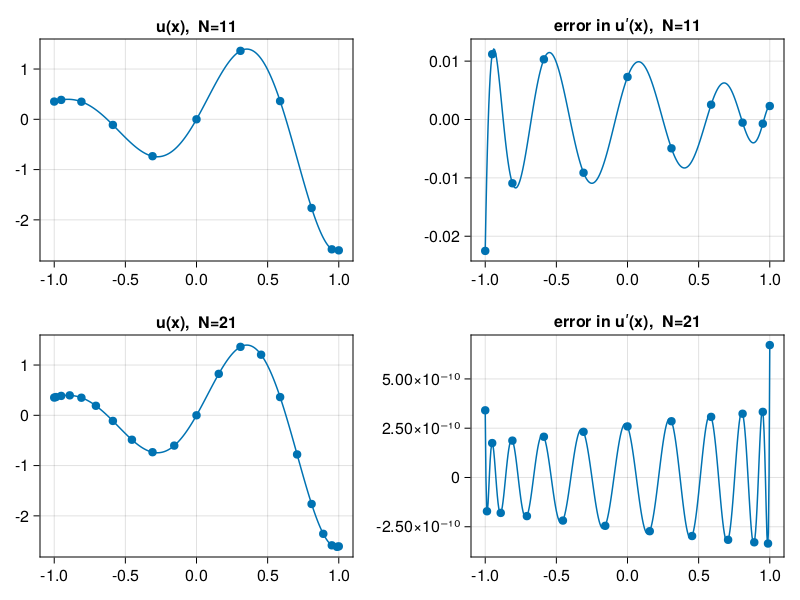

In [6]:
using CairoMakie
fig = Figure()
for (i,r) in enumerate(results)
    N = length(r.x)
    Axis(fig[i, 1], title="u(x),  N=$N")
    scatter!(r.x, r.v)
    lines!(xx, vv)
    Axis(fig[i, 2], title="error in uʹ(x),  N=$N")
    scatter!(r.x, r.error)
    lines!(xx, r.ee)
end
fig

### p12: accuracy of Chebyshev spectral differentiation

The effects of smoothness are illustrated more clearly here:

In [7]:
N = 1:50
# Compute derivatives for various values of N:
data = [ 
    # uʹʹʹ in BV
    (x -> abs(x)^3,  x -> 3x * abs(x), L"|x|^3"), 
    # C-infinity
    (x -> exp(-x^(-2)), x -> 2exp(-x^(-2)) / x^3, L"\exp(-x^{-2})"), 
    # analytic in [-1,1]
    (x -> 1 / (1 + x^2), x -> -2x / (1 + x^2)^2, L"1/(1+x^2)"),
    # polynomial 
    (x -> x^10, x -> 10x^9,  L"x^{10}")
]

results = []
for (i, (fun,deriv,title)) in enumerate(data)
    E = zeros(length(N))
    for (k,N) in enumerate(N)
        D, x = cheb(N)
        E[k] = norm(D*fun.(x) - deriv.(x), Inf)
    end
    push!(results, (;E, title))
end

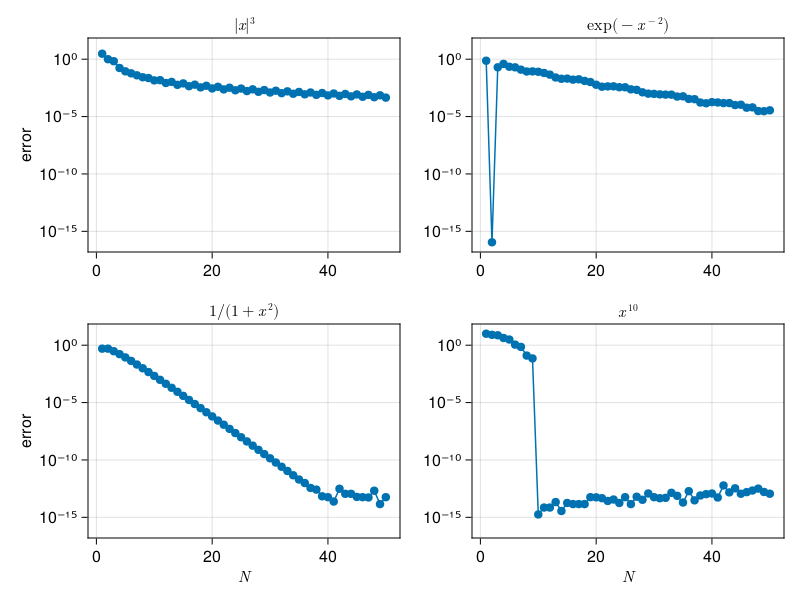

In [8]:
fig = Figure()
ax = [ Axis(fig[j,i], yscale=log10) for i in 1:2, j in 1:2 ]
for (ax,r) in zip(vec(ax),results)
    ax.title = r.title
    scatterlines!(ax, N, r.E)
end
linkxaxes!(ax...)
linkyaxes!(ax...)
ax[1,1].ylabel = ax[1,2].ylabel = "error"
ax[1,2].xlabel = ax[2,2].xlabel = L"N"
fig

The function $|x|^3$ has only 2 continuous derivatives, so the convergence is algebraic. Next, $e^{-x^2}$ is not analytic, and its convergence is between algebraic and exponential. The case $1/(1+x^2)$ is analytic around the interval, showing spectral convergence, and the function $x^{10}$ is the polynomial analog of "band-limited."